In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import os
import glob

Read and process opcode files

In [19]:
def read_opcode_files(base_path):
    data = []
    labels = []
    
    # Walk through all directories
    for apt_folder in os.listdir(base_path):
        apt_path = os.path.join(base_path, apt_folder)
        if os.path.isdir(apt_path):
            # Process each file in the APT folder
            for file_path in glob.glob(os.path.join(apt_path, '*')):
                with open(file_path, 'r') as f:
                    # Split by newline and join with commas
                    opcodes = f.read().strip()
                    opcodes = ', '.join(op.strip() for op in opcodes.split('\n') if op.strip())
                    data.append(opcodes)
                    labels.append(apt_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'Opcodes': data, 'APT': labels})
    
    # Print the first few rows of the DataFrame
    print("Preview of the DataFrame before n-gram extraction:")
    print(df.head())
    
    # Save to CSV
    output_path = 'opcodes_dataset.csv'
    df.to_csv(output_path, index=False)
    print(f"\nDataset saved to: {output_path}")
    
    return df


def extract_ngram_features(df, n=1):
    if n == 1:
        # Get all unique opcodes
        unique_ngrams = set()
        for opcodes in df['Opcodes']:
            unique_ngrams.update(op.strip() for op in opcodes.split(', '))
        
        # Sort the unique opcodes for consistent column ordering
        unique_ngrams = sorted(unique_ngrams)
        
        # Create a DataFrame with opcode frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_ngrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            counts = Counter(opcode_list)
            
            for opcode, count in counts.items():
                ngram_counts_df.at[i, opcode] = count
                
    elif n == 2:
        # Get all unique bigrams from the entire dataset first
        all_bigrams = set()
        for opcodes in df['Opcodes']:
            opcode_list = [op.strip() for op in opcodes.split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            all_bigrams.update(bigram_strings)
        
        # Sort the unique bigrams for consistent column ordering
        unique_bigrams = sorted(all_bigrams)
        
        # Create a DataFrame with bigram frequencies
        ngram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_bigrams)
        
        # Count frequencies for each sample
        for i, row in df.iterrows():
            opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
            bigrams = list(zip(opcode_list[:-1], opcode_list[1:]))
            bigram_strings = [f"{b[0]}_{b[1]}" for b in bigrams]
            counts = Counter(bigram_strings)
            
            for bigram, count in counts.items():
                ngram_counts_df.at[i, bigram] = count
    
    return ngram_counts_df.values, ngram_counts_df.columns.tolist()

# Example usage:
# Get both 1-gram and 2-gram features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)

# Convert to DataFrames using the columns from the feature extraction
feature_df_1gram = pd.DataFrame(X_1gram, columns=cols_1gram)
feature_df_2gram = pd.DataFrame(X_2gram, columns=cols_2gram)

print("Preview of 1-gram frequencies:")
print(feature_df_1gram.head())
print(f"\nNumber of unique 1-grams: {len(cols_1gram)}")

print("\nPreview of 2-gram frequencies:")
print(feature_df_2gram.head())
print(f"\nNumber of unique 2-grams: {len(cols_2gram)}")

Preview of 1-gram frequencies:
   A  AA  AAA  AAD  AAM  AAS  AB  ABCBFFFF  ABDAFFFF  ABFDFFFF  ...  X  XADD  \
0  0   0    0    0    0    0   0         0         0         0  ...  0     0   
1  0   0    0    0    0    0   0         0         0         0  ...  0     0   
2  0   0    0    0    0    0   0         0         0         0  ...  0     0   
3  0   0    0    0    0    0   0         0         0         0  ...  0     0   
4  0   0    0    0    0    0   0         0         0         0  ...  0     0   

   XADD.LOCK  XCHG  XGETBV  XLAT   XOR  XORPD  XORPS  Y  
0          0     0       0     0    98      0      0  0  
1          0     0       0     0    21      0      0  0  
2          0     3       0     0  1387      0      0  0  
3          0     0       0     0     1      0      0  0  
4          0     0       0     0     1      0      0  0  

[5 rows x 520 columns]

Number of unique 1-grams: 520

Preview of 2-gram frequencies:
   AAA_ADC  AAA_ADD  AAA_DEC  AAA_JNO  AAA_PUSH  AAA_

Read the data
Extract features
Combine features
Encode labels
Train/test split

In [20]:
base_path = '/Users/jeffreyjeyachandren/Desktop/opscode_ml/opcodes'  # Adjust this to your opscode folder path
df = read_opcode_files(base_path)

# Get features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)

# Combine features
X = np.concatenate([X_1gram, X_2gram], axis=1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['APT'])

# Print shape information
print(f"Shape of 1-gram features: {X_1gram.shape}")
print(f"Shape of 2-gram features: {X_2gram.shape}")
print(f"Shape of combined features: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Split and continue with classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preview of the DataFrame before n-gram extraction:
                                             Opcodes            APT
0  JMP, JMP, JMP, JMP, JMP, JMP, JMP, JMP, POP, P...        Evilnum
1  PUSH, MOV, MOV, CALL, PUSH, PUSH, PUSH, PUSH, ...  APT19_opcodes
2  MOV, PUSH, MOV, CALL, TEST, PUSH, CALL, ADD, M...  APT19_opcodes
3  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes
4  PUSH, PUSH, PUSH, MOV, CMP, JE, CMP, JNE, PUSH...  APT19_opcodes

Dataset saved to: opcodes_dataset.csv
Shape of 1-gram features: (215, 520)
Shape of 2-gram features: (215, 5653)
Shape of combined features: (215, 6173)
Number of classes: 32


In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'SVM': SVC(kernel='rbf'),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
        # Get unique classes present in the test set
    unique_classes = np.unique(y_test)
    target_names = le.inverse_transform(unique_classes)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, 
                                 labels=unique_classes,
                                 target_names=target_names)
    
    results[name] = {
        'accuracy': accuracy,
        'report': report
    }

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Results

In [22]:
# Print results
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("\nClassification Report:")
    print(result['report'])


SVM Results:
Accuracy: 0.3023

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.29      0.33      0.31         6
  APT30_opcodes       0.00      0.00      0.00         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.31      1.00      0.48        11
       Sandworm       0.00      0.00      0.00         1
          Turla       0.00      

Evaluate the classifiers when using 1-gram and 2-gram features

In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


def evaluate_classifier(clf, X_train, X_test, y_train, y_test, le, name):
    # Train and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get unique classes present in the test set
    unique_classes = np.unique(y_test)
    target_names = le.inverse_transform(unique_classes)
    
    # Generate classification report with correct labels
    report = classification_report(y_test, y_pred, 
                                 labels=unique_classes,
                                 target_names=target_names)
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(report)
    print("-" * 80 + "\n")
    
    return accuracy

# Get features
X_1gram, cols_1gram = extract_ngram_features(df, n=1)
X_2gram, cols_2gram = extract_ngram_features(df, n=2)
X_combined = np.concatenate([X_1gram, X_2gram], axis=1)

# Scale all feature sets
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)
X_combined_scaled = scaler.fit_transform(X_combined)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['APT'])

# Initialize classifiers
classifiers = {
    'SVM': SVC(kernel='rbf'),
    'KNN-3': KNeighborsClassifier(n_neighbors=3),
    'KNN-5': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier()
}

# Dictionary to store results
results = {
    '1-gram': {},
    '2-gram': {},
    'combined': {}
}

# Evaluate each feature set
feature_sets = {
    '1-gram': X_1gram_scaled,
    '2-gram': X_2gram_scaled,
    'combined': X_combined_scaled
}

for feature_name, X in feature_sets.items():
    print(f"\nEvaluating {feature_name} features:")
    print(f"Feature dimension: {X.shape}")
    print("-" * 80)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Evaluate each classifier
    for clf_name, clf in classifiers.items():
        accuracy = evaluate_classifier(clf, X_train, X_test, y_train, y_test, le, clf_name)
        results[feature_name][clf_name] = accuracy

# Print comparison summary
print("\nAccuracy Comparison Summary:")
print("-" * 80)
print(f"{'Classifier':<15} {'1-gram':>10} {'2-gram':>10} {'Combined':>10}")
print("-" * 80)
for clf_name in classifiers.keys():
    print(f"{clf_name:<15} {results['1-gram'][clf_name]:>10.4f} {results['2-gram'][clf_name]:>10.4f} {results['combined'][clf_name]:>10.4f}")


Evaluating 1-gram features:
Feature dimension: (215, 520)
--------------------------------------------------------------------------------
SVM Results:
Accuracy: 0.3721

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.50      0.67      0.57         6
  APT30_opcodes       0.00      0.00      0.00         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
       

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Decision Tree Results:
Accuracy: 0.4186

Classification Report:
                 precision    recall  f1-score   support

  APT12_opcodes       0.00      0.00      0.00         1
  APT17_opcodes       0.00      0.00      0.00         1
   APT1_opcodes       0.00      0.00      0.00         4
          APT28       0.00      0.00      0.00         3
          APT29       0.36      0.83      0.50         6
  APT30_opcodes       0.75      1.00      0.86         3
BlueMockingbird       0.00      0.00      0.00         1
      Elderwood       0.00      0.00      0.00         1
           FIN7       0.00      0.00      0.00         1
        Gallium       0.00      0.00      0.00         1
      Gamaredon       0.00      0.00      0.00         1
       Ke3chang       0.00      0.00      0.00         2
       MenuPass       0.00      0.00      0.00         1
         Moafee       0.75      0.82      0.78        11
       Sandworm       0.33      1.00      0.50         1
          Turla       0

/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeffreyjeyachandren/Desktop/opscode_ml/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Plot the results


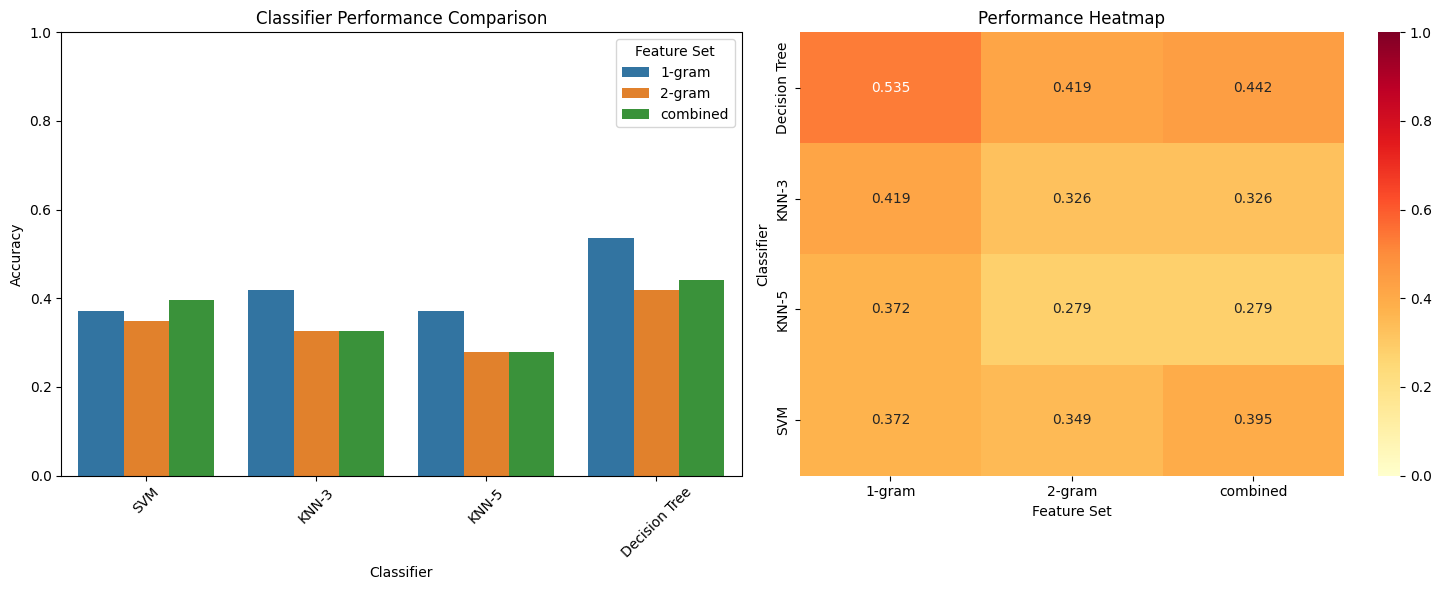


Detailed Statistics:
--------------------------------------------------------------------------------

Best performing combinations:
Best overall: Decision Tree with 1-gram features (Accuracy: 0.5349)

Best classifier for each feature set:
1-gram: Decision Tree (Accuracy: 0.5349)
2-gram: Decision Tree (Accuracy: 0.4186)
combined: Decision Tree (Accuracy: 0.4419)

Best feature set for each classifier:
SVM: combined (Accuracy: 0.3953)
KNN-3: 1-gram (Accuracy: 0.4186)
KNN-5: 1-gram (Accuracy: 0.3721)
Decision Tree: 1-gram (Accuracy: 0.5349)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to a format suitable for plotting
plot_data = {
    'Classifier': [],
    'Feature Set': [],
    'Accuracy': []
}

for feature_set in results:
    for classifier in results[feature_set]:
        plot_data['Classifier'].append(classifier)
        plot_data['Feature Set'].append(feature_set)
        plot_data['Accuracy'].append(results[feature_set][classifier])

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(plot_data)

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# 1. Bar Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Classifier', y='Accuracy', hue='Feature Set', data=plot_df)
plt.title('Classifier Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1

# 2. Heatmap
plt.subplot(1, 2, 2)
heatmap_data = plot_df.pivot(index='Classifier', columns='Feature Set', values='Accuracy')
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.title('Performance Heatmap')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
print("-" * 80)
print("\nBest performing combinations:")
best_idx = plot_df['Accuracy'].idxmax()
print(f"Best overall: {plot_df.iloc[best_idx]['Classifier']} with {plot_df.iloc[best_idx]['Feature Set']} features "
      f"(Accuracy: {plot_df.iloc[best_idx]['Accuracy']:.4f})")

# Best for each feature set
print("\nBest classifier for each feature set:")
for feature_set in results:
    best_clf = max(results[feature_set].items(), key=lambda x: x[1])
    print(f"{feature_set}: {best_clf[0]} (Accuracy: {best_clf[1]:.4f})")

# Best for each classifier
print("\nBest feature set for each classifier:")
for classifier in classifiers:
    accuracies = {
        feature_set: results[feature_set][classifier]
        for feature_set in results
    }
    best_features = max(accuracies.items(), key=lambda x: x[1])
    print(f"{classifier}: {best_features[0]} (Accuracy: {best_features[1]:.4f})")

Now we want to balance the dataset so it is not skewed towards the majority classes

In [31]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

def balance_and_evaluate(X, y, classifiers, le):
    # Print original class distribution
    original_dist = Counter(le.inverse_transform(y))
    print("Original class distribution:")
    print(original_dist)
    
    # First use RandomOverSampler to handle classes with single samples
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    
    # Then apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X_ros, y_ros)
    
    print("\nBalanced class distribution:")
    print(Counter(le.inverse_transform(y_balanced)))
    
    # Split the balanced dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Dictionary to store results
    results = {}
    
    # Evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, 
                                    target_names=le.classes_,
                                    zero_division=0)
        
        results[name] = {
            'accuracy': accuracy,
            'report': report
        }
        
        print(f"\n{name} Results (with balanced data):")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        print("-" * 80)
    
    return results

# Initialize classifiers with balanced settings
classifiers = {
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'KNN-3': KNeighborsClassifier(n_neighbors=3, weights='distance'),
    'KNN-5': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', 
                                          max_depth=10,
                                          min_samples_split=5)
}

# Scale features
scaler = StandardScaler()
X_1gram_scaled = scaler.fit_transform(X_1gram)
X_2gram_scaled = scaler.fit_transform(X_2gram)
X_combined_scaled = scaler.fit_transform(X_combined)

# Evaluate with balanced classes
print("\nEvaluating 1-gram features:")
results_1gram = balance_and_evaluate(X_1gram_scaled, y, classifiers, le)

print("\nEvaluating 2-gram features:")
results_2gram = balance_and_evaluate(X_2gram_scaled, y, classifiers, le)

print("\nEvaluating combined features:")
results_combined = balance_and_evaluate(X_combined_scaled, y, classifiers, le)

# Print comparison summary
print("\nAccuracy Comparison Summary (with balanced data):")
print("-" * 80)
print(f"{'Classifier':<15} {'1-gram':>10} {'2-gram':>10} {'Combined':>10}")
print("-" * 80)
for clf_name, _ in classifiers.items():  # Unpack the tuple to get just the name
    print(f"{clf_name:<15} {results_1gram[clf_name]['accuracy']:>10.4f} "
          f"{results_2gram[clf_name]['accuracy']:>10.4f} "
          f"{results_combined[clf_name]['accuracy']:>10.4f}")


Evaluating 1-gram features:
Original class distribution:
Counter({'Moafee': 45, 'APT29': 40, 'Turla': 24, 'APT28': 21, 'APT1_opcodes': 15, 'APT30_opcodes': 15, 'APT19_opcodes': 8, 'Sandworm': 7, 'Ke3chang': 5, 'APT12_opcodes': 5, 'Gallium': 5, 'admin38_opcodes': 2, 'FIN7': 2, 'CobaltGroup': 2, 'MenuPass': 2, 'Evilnum': 1, 'BlueMockingbird': 1, 'Dragonfly': 1, 'Dragonfly2.0': 1, 'DarkVishnya': 1, 'bronze_butler_opcodes': 1, 'Patchwork': 1, 'deep_panda_opcodes': 1, 'AjaxSecurityTeam': 1, 'Elderwood': 1, 'Sidewinder': 1, 'APT17_opcodes': 1, 'Gamaredon': 1, 'chimera_opcodes': 1, 'APT39': 1, 'APT41_opcodes': 1, 'TEMP.VELES': 1})

Balanced class distribution:
Counter({'Evilnum': 45, 'APT19_opcodes': 45, 'BlueMockingbird': 45, 'Dragonfly': 45, 'Dragonfly2.0': 45, 'APT29': 45, 'DarkVishnya': 45, 'Sandworm': 45, 'Turla': 45, 'APT28': 45, 'admin38_opcodes': 45, 'FIN7': 45, 'bronze_butler_opcodes': 45, 'Ke3chang': 45, 'APT1_opcodes': 45, 'Patchwork': 45, 'deep_panda_opcodes': 45, 'APT12_opcodes'

Plot the results post-balancing


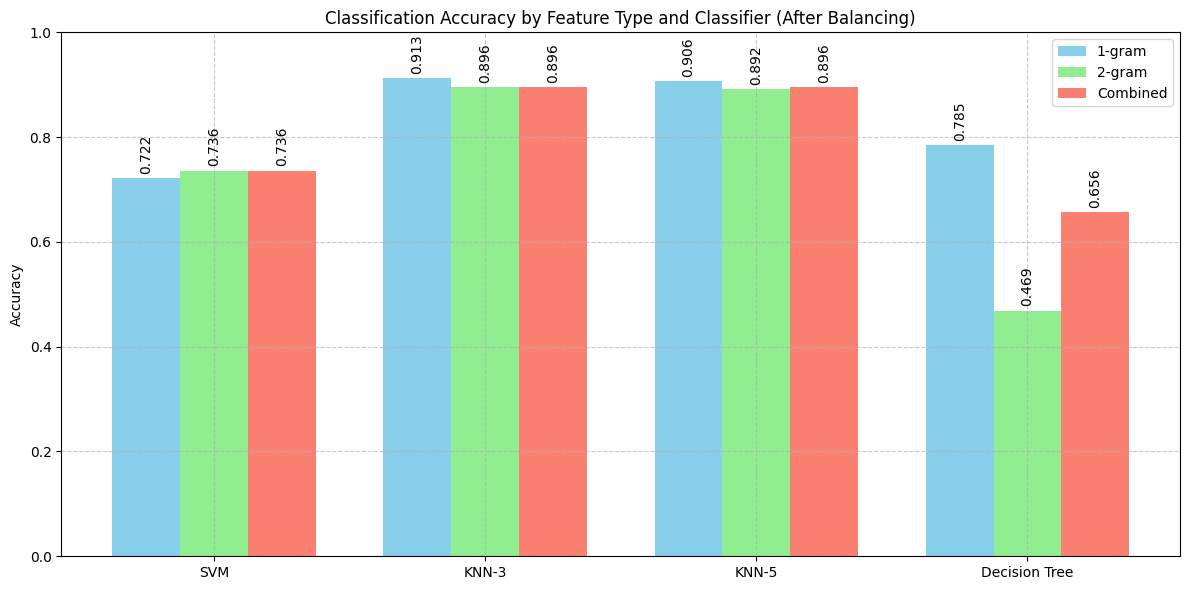

In [32]:
# Data
classifiers = ['SVM', 'KNN-3', 'KNN-5', 'Decision Tree']
accuracies_1gram = [0.7222, 0.9132, 0.9062, 0.7847]
accuracies_2gram = [0.7361, 0.8958, 0.8924, 0.4688]
accuracies_combined = [0.7361, 0.8958, 0.8958, 0.6562]

# Set up bar width and positions
x = np.arange(len(classifiers))
width = 0.25

# Create bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracies_1gram, width, label='1-gram', color='skyblue')
rects2 = ax.bar(x, accuracies_2gram, width, label='2-gram', color='lightgreen')
rects3 = ax.bar(x + width, accuracies_combined, width, label='Combined', color='salmon')

# Customize the plot
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy by Feature Type and Classifier (After Balancing)')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Set y-axis limits to start from 0 and end at 1
plt.ylim(0, 1.0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()